<a href="https://colab.research.google.com/github/pdrobny/MonReader/blob/main/P4_LLaVa_text_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import userdata
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datasets import load_metric
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# load files from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


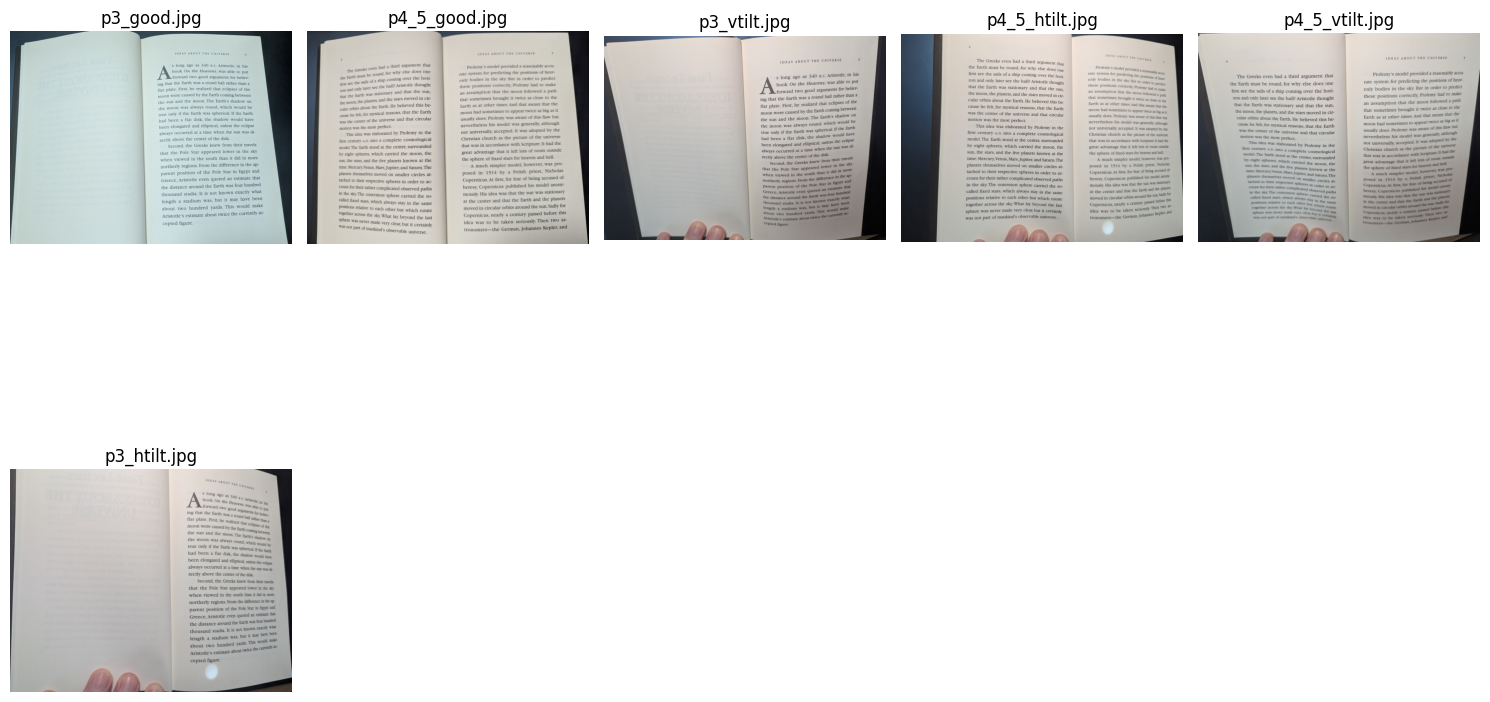

In [ ]:
image_dir = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg'))]

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_files):
  if i < 10: # Limit the number of images shown
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
  else:
    break
plt.tight_layout()
plt.show()


In [ ]:
image_files

['/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_good.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_good.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_vtilt.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_htilt.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_vtilt.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_htilt.jpg']

In [ ]:
p3_good = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_good.jpg'
p4_5_good = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_good.jpg'
p3_vtilt = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_vtilt.jpg'
p3_htilt = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_htilt.jpg'
p4_5_vtilt = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_vtilt.jpg'
p4_5_htilt = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_htilt.jpg'


In [ ]:
p3_actual = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_actual.txt'
p4_5_actual = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_actual.txt'

## LLaVa

In [ ]:
# Load model
model_id = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

In [ ]:
# Image paths
image_paths = {
    "p3_good": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_good.jpg",
    "p4_5_good": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_good.jpg"#,
    #"p3_vtilt": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_vtilt.jpg",
    #"p3_htilt": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_htilt.jpg",
    #"p4_5_vtilt": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_vtilt.jpg",
    #"p4_5_htilt": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_htilt.jpg"
}

# Actual reference text
actual_text_paths = {
    "p3": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p3_actual.txt",
    "p4_5": "/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/books/p4_5_actual.txt"
}
with open(actual_text_paths["p3"], "r") as f:
    actual_p3_text = f.read()
with open(actual_text_paths["p4_5"], "r") as f:
    actual_p4_5_text = f.read()


In [ ]:
# BLEU scoring function
def compute_bleu(reference, hypothesis):
    ref_tokens = word_tokenize(reference.lower())
    hyp_tokens = word_tokenize(hypothesis.lower())
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)

# LLaVA inference function
def extract_text(image_path, prompt):
    image = Image.open(image_path).convert("RGB")
    # Add the image token to the prompt
    prompt_with_image_token = "<image>\n" + prompt
    inputs = processor(text=prompt_with_image_token, images=image, return_tensors="pt").to("cuda", torch.float16)
    ids = model.generate(**inputs, max_new_tokens=512)
    return processor.batch_decode(ids, skip_special_tokens=True)[0].strip()


In [ ]:
# Prompts to try
prompts = [
    #"Please transcribe the text from this book page exactly as it appears, word for word.",
    "Extract the text written on this book page.  Show me the complete text.  Do not summarize",  # summarize all pages
    #"Extract the complete text written on this book page. Do not summarize.", # summarizes 3rd page not 4thand 5th
    #"You are an OCR text extractor.  What is the text written on this book page. Do not summarize.",  ## Generates a summary
    #"You are an automated book reader to assist the visually impaired.  What is the exact text written on this book page. Do not summarize."

]


In [ ]:


# Evaluate each image using all prompts
for name, path in image_paths.items():
    print(f"\n================ Evaluating: {name} ================")
    actual_text = actual_p3_text if "p3" in name else actual_p4_5_text

    best_bleu = -1
    best_text = ""
    best_prompt = ""

    for prompt in prompts:
        extracted = extract_text(path, prompt)
        bleu = compute_bleu(actual_text, extracted)

        if bleu > best_bleu:
            best_bleu = bleu
            best_text = extracted
            best_prompt = prompt

    print(f"\n✅ Best BLEU Score: {best_bleu:.4f}")
    print(f"🧠 Best Prompt: \"{best_prompt}\"\n")
    print("--- Extracted Text ---\n")
    print(best_text[:1000])
    print("\n--- Reference Text ---\n")
    print(actual_text.strip()[:1000])


================ Evaluating: p3_good ================

✅ Best BLEU Score: 0.0161
🧠 Best Prompt: "Extract the text written on this book page.  Show me the complete text.  Do not summarize"

--- Extracted Text ---

Extract the text written on this book page.  Show me the complete text.  Do not summarize. 

The book is about the universe and the earth. The author talks about the moon and the sun. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the earth and the moon. The book is about the earth and the moon. The author talks about the